In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch

In [2]:
import midaa as maa

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# We assume all the data is downloaded in a ../data directory

# We need to convert names from scDNA to scRNA
common_names =  pd.read_csv("../data/GSE158067_scRNA_filename_key_to_scDNAme.csv")

In [5]:
meta_rna =  pd.read_csv("../data/GSE158067_scRNA_cell_metadata.csv", sep = ";")
meta_meth = pd.read_csv("../data/GSE158067_scDNAme_cell_metadata.csv", sep =";" )

In [6]:
# We intersect names to find cells that have both RNA and Meth

common_names = common_names[common_names["DNAme_cell_ID"].isin(meta_meth["DNAme_cell_ID"])]
common_names = common_names[common_names["RNA_cell_ID"].isin(meta_rna["RNA_cell_ID"])]

In [7]:
rna = pd.read_csv("../data/GSE158067_gene_exp_mtx.txt", sep = " ")

In [8]:
# We just format the pandas df

meth = pd.read_csv("../data/GSE158067_filt_CpG_meth_g25.csv")
meth.index = meth["Unnamed: 0"]
meth = meth.drop(columns = "Unnamed: 0")

In [9]:
# Again boring name formatting

meth.columns = meth.columns.str.replace(".R1.*","" ,regex = True)
meth = meth[list(set(common_names["DNAme_cell_ID"]).intersection(meth.columns))]

common_names_filt = common_names[common_names["DNAme_cell_ID"].isin(meth.columns)]

rna = rna[list(set(common_names_filt["RNA_cell_ID"]).intersection(rna.columns))]

In [11]:
# Here we filter CpGs with some variability i.e. at least 65% of non missing data

not_empty = np.sum(meth.values != "-", axis = 1)
meth = meth[not_empty >= (0.65 * meth.shape[1])]


In [14]:
# We make the final matrices

X_rna = rna[common_names_filt["RNA_cell_ID"]].values
X_meth = meth[common_names_filt["DNAme_cell_ID"]].values

In [15]:
# We set missing data to 0

X_meth[X_meth == "-"] = 0
X_meth = X_meth.astype(np.float16)

In [16]:
# We need samples x features so we transpose


X_meth = X_meth.T
X_rna = X_rna.T

In [17]:
# From here on we just analyze the RNA data 
# Similarly to what has been done in the original paper

import anndata as ad
 

adata = ad.AnnData(X_rna)
adata.obs_names = common_names_filt["RNA_cell_ID"]
adata.var_names = rna.index

/tmp/ipykernel_2278613/897797125.py:4: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X_rna)


In [18]:
meta_rna.index = meta_rna["RNA_cell_ID"]


In [19]:
adata.obs = meta_rna.loc[adata.obs.index,:]

In [20]:
import scanpy as sc
import scanpy.external as sce

sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.scanorama_integrate(adata, 'Sample', knn=30)
sc.pp.neighbors(adata, use_rep = "X_scanorama", n_neighbors = 30)
sc.tl.leiden(adata)
sc.tl.umap(adata)


[[0.         0.99621212]
 [0.         0.        ]]
Processing datasets CH02 <=> CH04


In [22]:
adata

AnnData object with n_obs × n_vars = 516 × 4061
    obs: 'RNA_cell_ID', '# Reads', '# Genes', '% Mitochondrial reads', '% Ribosomal reads', 'No_mutant_reads', 'No_wt_reads', 'Genotype', 'Plate', 'Sample', 'Type', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [23]:
# We will use the scanorama integrated space as input

X_rna_aa = adata.obsm["X_scanorama"]

In [139]:
# We look for a reasonable number of archetypes by iterating from 2 to 12
# This takes a while especially without GPU, if you want to use the 
# exact same model we used in the paper skip this cells and go down

MULT = 4

models  = {}

for i in range(2, 12):

    models[i] = maa.fit_maa(
        [X_rna_aa, X_meth],
        [np.ones(X_rna_aa.shape[0]), np.ones(X_meth.shape[0])],
        ["G", "B"],
        #side_matrices = [side_mat], 
        #input_types_side = ["C"],
        #loss_weights_side = [1e2],
        #loss_weights_reconstruction = [1, 1],
        hidden_dims_dec_common = [32 * MULT, 64 * MULT],
        hidden_dims_dec_last = [64 * MULT, 128 * MULT],
        hidden_dims_enc_ind = [128 * MULT, 64 * MULT],
        hidden_dims_enc_common = [64 * MULT],
        hidden_dims_enc_pre_Z = [32 * MULT],
        lr = 0.0001,
        gamma_lr = 0.1,
        steps = 1000,
        narchetypes = i,
        batch_size = 300,
        fix_Z = False,
        torch_seed = 3
    )

ELBO: 167657.26562  : 100%|██████████| 1000/1000 [00:47<00:00, 21.22it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
ELBO: 153899.56250  : 100%|██████████| 1000/1000 [00:40<00:00, 24.60it/s]


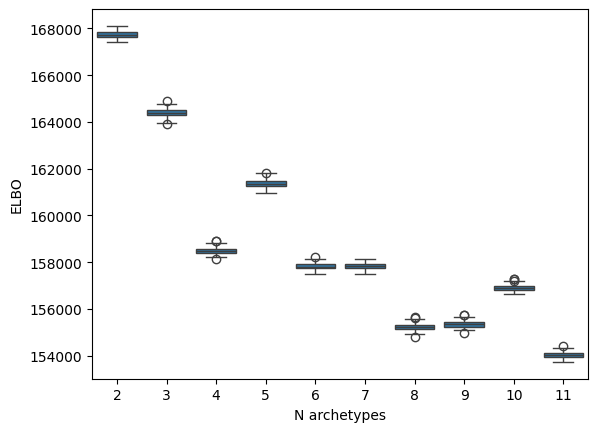

In [25]:
maa.plot_ELBO_across_runs(models, 900)

In [26]:
# 4 looks good as a parsimonius model

best_model = models[4]

In [27]:
# MIDAA object structure

best_model.keys()

dict_keys(['inferred_quantities', 'hyperparametes', 'ELBO', 'deepAA_obj'])

In [28]:
# We save the results

torch.save(best_model["deepAA_obj"].state_dict(), "best_model_aa_state_dict.pth")
torch.save(best_model["inferred_quantities"], "best_model_aa_inferred_quantities.pth")

elbo_dict = {k:v["ELBO"] for k,v in models.items()}
torch.save(elbo_dict,"ELBO_dict.pth")

In [24]:
# Given that the torch seed does not guarantee perfect
# reproducibility across machines, we give the inference
# results we got in the paper


# First you need to initialize the model 

MULT = 4

best_model = maa.fit_maa(
    [X_rna_aa, X_meth],
    [np.ones(X_rna_aa.shape[0]), np.ones(X_meth.shape[0])],
    ["G", "B"],
    #side_matrices = [side_mat], 
    #input_types_side = ["C"],
    #loss_weights_side = [1e2],
    #loss_weights_reconstruction = [1, 1],
    hidden_dims_dec_common = [32 * MULT, 64 * MULT],
    hidden_dims_dec_last = [64 * MULT, 128 * MULT],
    hidden_dims_enc_ind = [128 * MULT, 64 * MULT],
    hidden_dims_enc_common = [64 * MULT],
    hidden_dims_enc_pre_Z = [32 * MULT],
    lr = 0.0001,
    gamma_lr = 0.1,
    steps = 0,
    narchetypes = 4,
    batch_size = 300,
    fix_Z = False,
    torch_seed = 3
)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


In [26]:
# Now we can finally load the weights for the neural nets

maa.load_model_from_state_dict(best_model,[X_rna_aa, X_meth], "best_model_aa_state_dict.pth")

In [27]:
# We add the information in the adata object

adata, arc_names = maa.add_to_obs_adata(best_model, adata)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


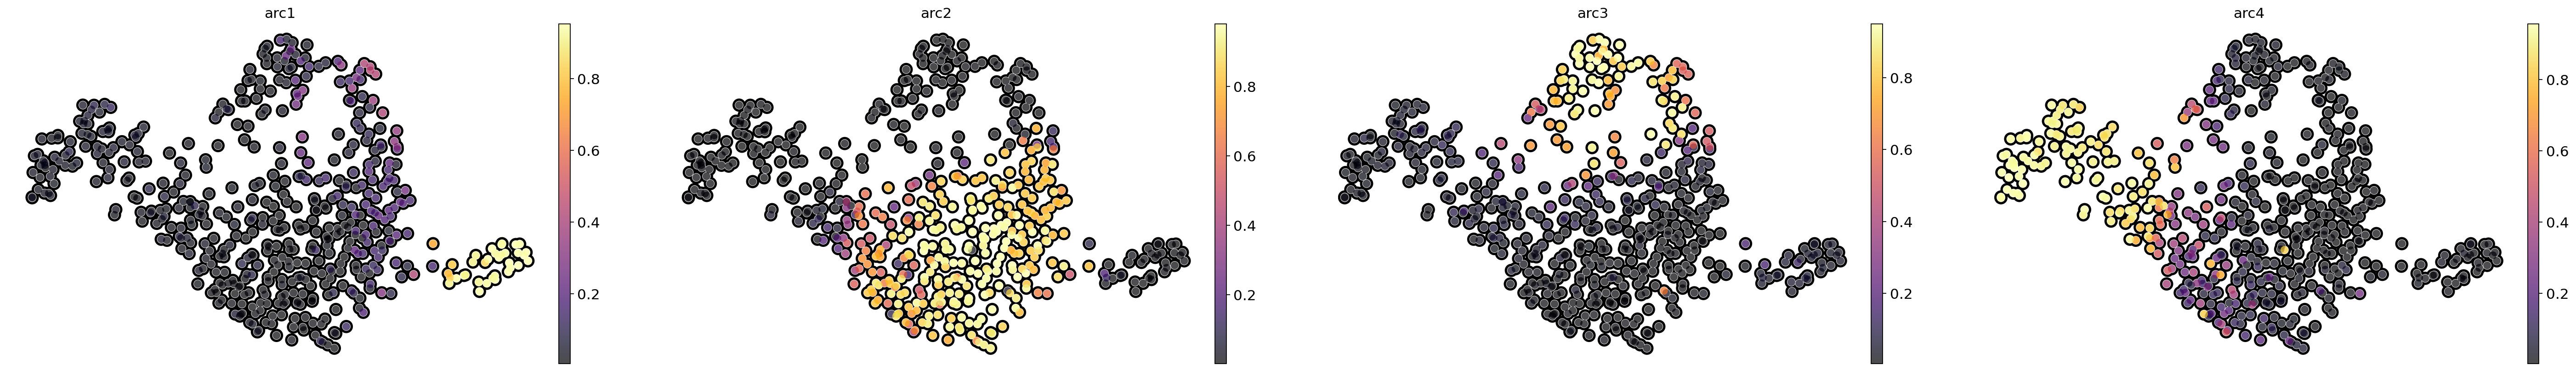

In [28]:
sc.set_figure_params(dpi_save = 600, figsize = [10,6])

sc.pl.umap(adata, color=arc_names, cmap = "inferno", frameon = False, add_outline=True)

In [30]:
maa.plot_archetypes_simplex(best_model,  s =  30)



In [31]:
maa.plot_archetypes_simplex(best_model, color_by = adata.obs["Genotype"], cmap = "Set1", s =  10, l_title = "Genotype")



In [32]:
# Here we just load the gene sets used in the original paper for cell type progenitors

scores = pd.read_csv("landau_scoring.csv", sep = ";")
scores_list = scores.to_dict(orient='list')

In [34]:
# We now calculate a score for each cell type


sc.tl.score_genes(adata, scores_list["HSPC module"], score_name = "HSPC")
sc.tl.score_genes(adata, scores_list["IMP module"],  score_name = "IMP")
sc.tl.score_genes(adata, scores_list["EP  module"],  score_name = "EP")
sc.tl.score_genes(adata, scores_list["NP  module"],  score_name = "NP")

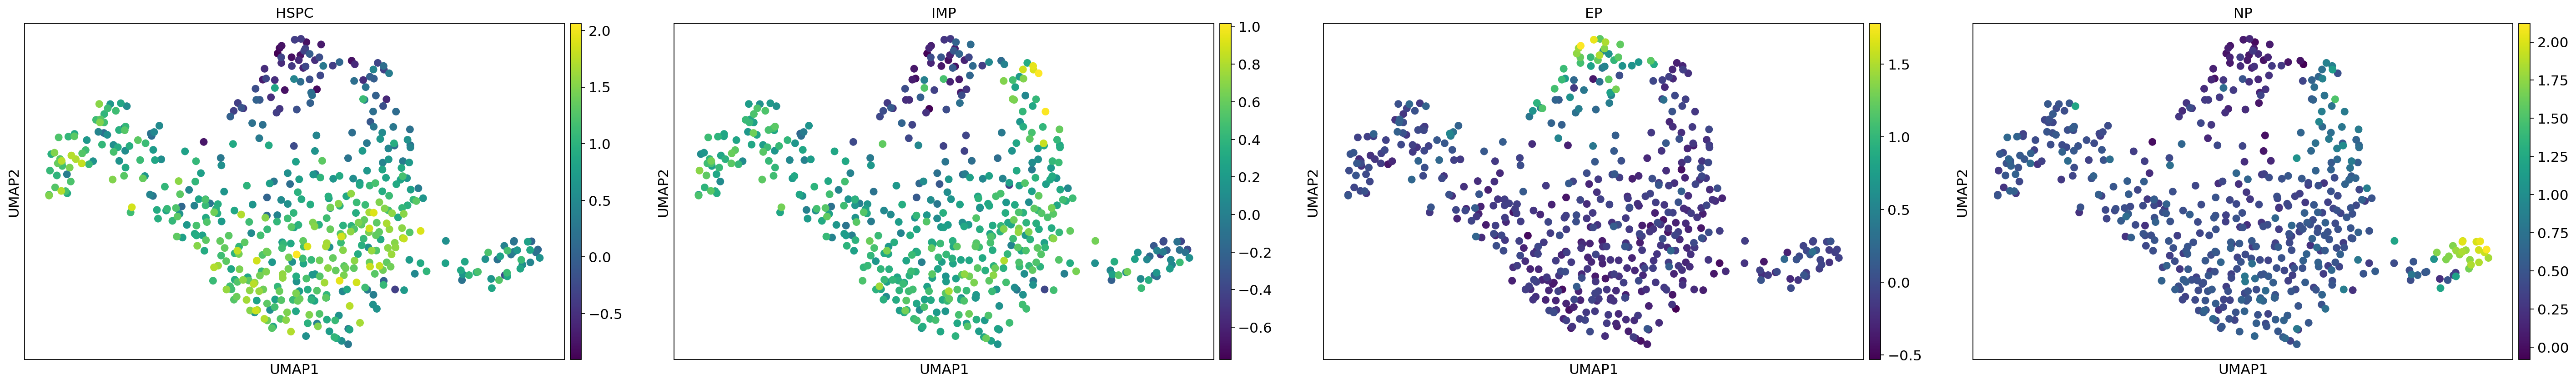

In [35]:
# We see how they are distributed to the boundaries of the UMAP (ofc looking at stuff in UMAP in general = "no good")

sc.pl.umap(adata, color=["HSPC", "IMP", "EP", "NP"])

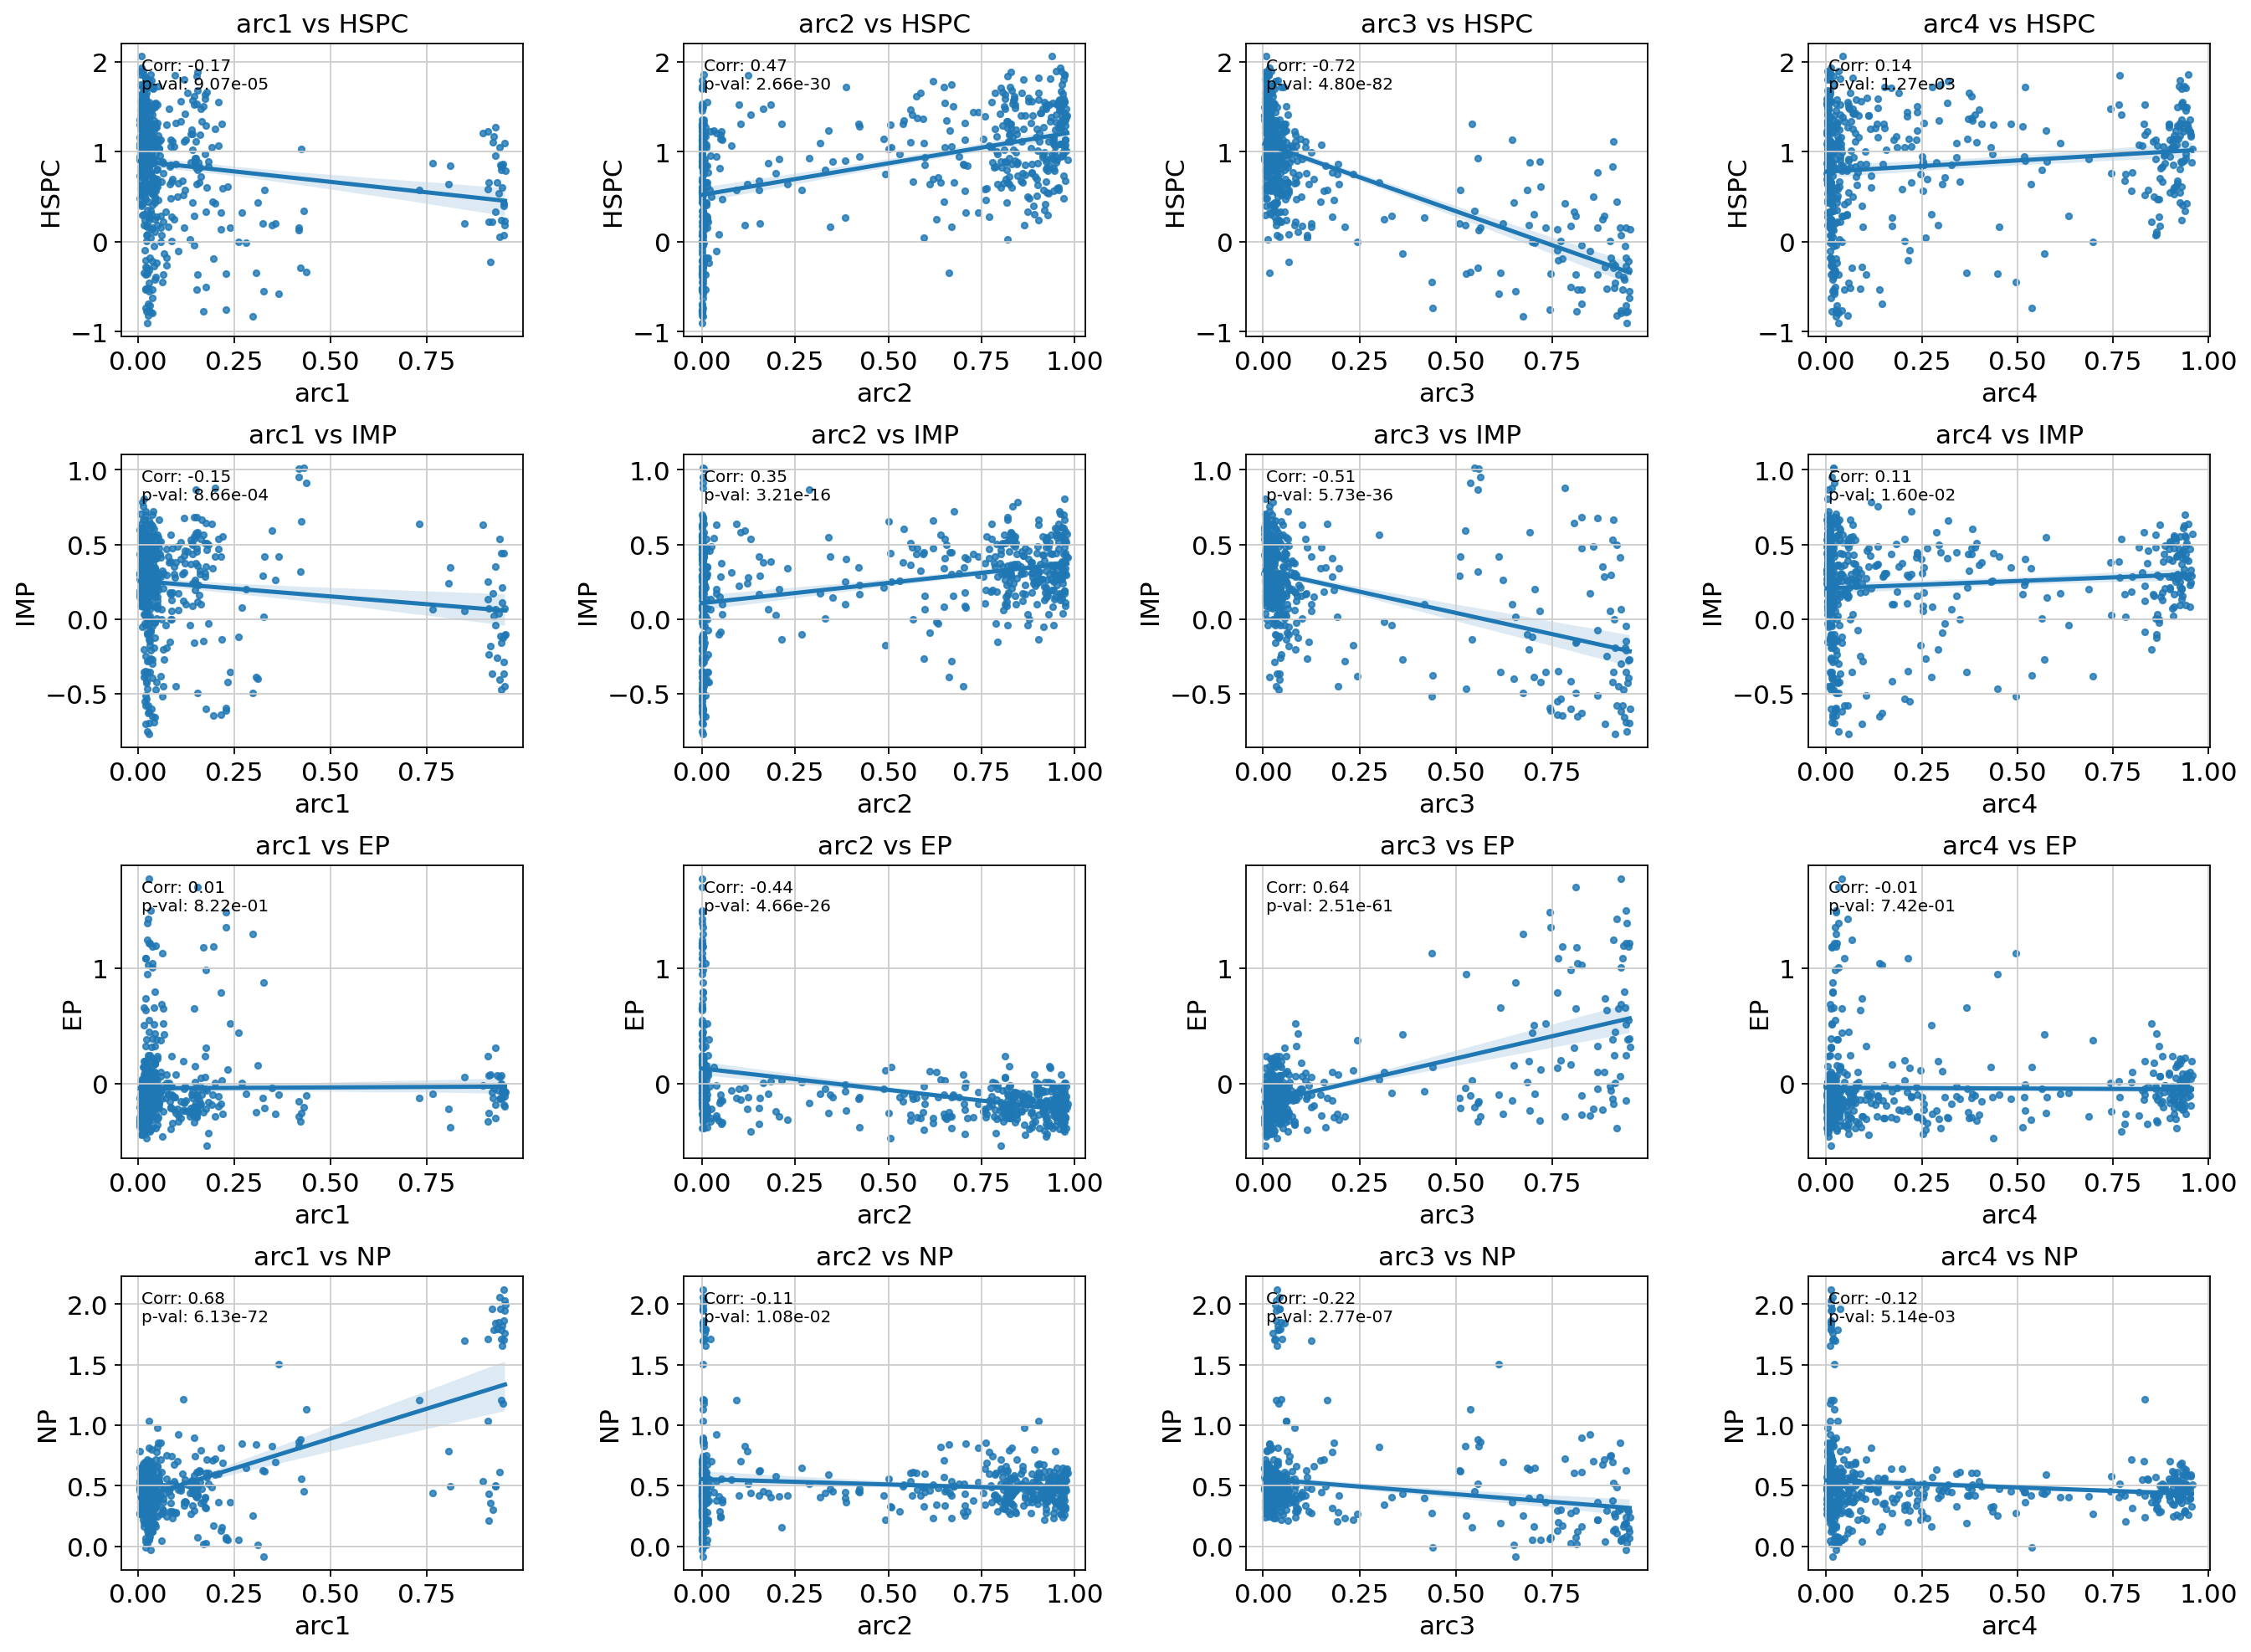

In [37]:
# We are just making a correlation pair plot with the archetypes

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

df = adata.obs
arch_vars = [col for col in df.columns if col.startswith('arc')]
specific_vars = ["HSPC", "IMP", "EP", "NP"]

# Determine the size of the grid
grid_size = (len(specific_vars), len(arch_vars)) # Rows x Columns

# Create a figure to hold the grid
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjust space between plots

# Iterate over each specific variable and 'arch' variable to plot
for i, spec_var in enumerate(specific_vars):
    for j, arch_var in enumerate(arch_vars):
        # Current axis
        ax = axes[i, j]
        
        # Plot data and regression line with seaborn
        sns.regplot(x=arch_var, y=spec_var, data=df, ax=ax, scatter_kws={'s': 10})
        
        
        # Calculate correlation and p-value
        corr, p_value = pearsonr(df[arch_var], df[spec_var])
        
        # Annotate plot with correlation and p-value
        ax.text(0.05, 0.95, f'Corr: {corr:.2f}\np-val: {p_value:.2e}', transform=ax.transAxes, 
                verticalalignment='top', fontsize=9)
        
        # Set title
        ax.set_title(f'{arch_var} vs {spec_var}')

# Show plot
plt.show()

In [43]:
# Now we run MOFA, as usual we also give the pre-computed model

from mofapy2.run.entry_point import entry_point
import pandas as pd
import numpy as np

# initialise the entry point
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [44]:
data_mat = [[X_rna_aa], [X_meth]]

In [45]:
ent.set_data_matrix(data_mat, likelihoods = ["gaussian","bernoulli"])
# We first try to look at a model comparable with the archetypes
ent.set_model_options(factors = 4)

View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='view0' group='group0' with N=516 samples and D=50 features...
Successfully loaded view='view1' group='group0' with N=516 samples and D=53 features...


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (view0): gaussian
- View 1 (view1): bernoulli




In [46]:
ent.set_train_options(seed = 3)

In [47]:
ent.build()

ent.run()

# Save the output
ent.save(outfile="mofa_on_emato.hd5")



######################################
## Training the model with seed 3 ##
######################################


ELBO before training: -351519.12 

Iteration 1: time=0.04, ELBO=-110271.08, deltaELBO=241248.048 (68.63013469%), Factors=4
Iteration 2: time=0.01, ELBO=-88535.64, deltaELBO=21735.435 (6.18328667%), Factors=4
Iteration 3: time=0.01, ELBO=-86842.27, deltaELBO=1693.368 (0.48172855%), Factors=4
Iteration 4: time=0.01, ELBO=-85362.67, deltaELBO=1479.607 (0.42091791%), Factors=4
Iteration 5: time=0.01, ELBO=-84404.97, deltaELBO=957.696 (0.27244481%), Factors=4
Iteration 6: time=0.01, ELBO=-83724.14, deltaELBO=680.828 (0.19368170%), Factors=4
Iteration 7: time=0.00, ELBO=-83285.85, deltaELBO=438.291 (0.12468478%), Factors=4
Iteration 8: time=0.00, ELBO=-82988.41, deltaELBO=297.445 (0.08461707%), Factors=4
Iteration 9: time=0.00, ELBO=-82773.28, deltaELBO=215.121 (0.06119766%), Factors=4
Iteration 10: time=0.00, ELBO=-82617.66, deltaELBO=155.620 (0.04427057%), Factors=4
Iterat

In [48]:
# Than we a full model more inline to what you would actually do,
# but less parsimonious

ent.set_model_options(factors = 30)

Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (view0): gaussian
- View 1 (view1): bernoulli




In [49]:
ent.set_train_options(seed = 3)

ent.build()

ent.run()

ent.save(outfile="mofa_on_emato_full.hd5")



######################################
## Training the model with seed 3 ##
######################################


ELBO before training: -773014.63 

Iteration 1: time=0.03, ELBO=-164508.46, deltaELBO=608506.173 (78.71858417%), Factors=30
Iteration 2: time=0.02, ELBO=-94285.48, deltaELBO=70222.977 (9.08430110%), Factors=30
Iteration 3: time=0.02, ELBO=-88949.10, deltaELBO=5336.381 (0.69033374%), Factors=30
Iteration 4: time=0.02, ELBO=-87685.41, deltaELBO=1263.692 (0.16347585%), Factors=30
Iteration 5: time=0.02, ELBO=-86662.02, deltaELBO=1023.384 (0.13238868%), Factors=30
Iteration 6: time=0.02, ELBO=-85952.66, deltaELBO=709.369 (0.09176661%), Factors=30
Iteration 7: time=0.02, ELBO=-85420.34, deltaELBO=532.316 (0.06886228%), Factors=30
Iteration 8: time=0.02, ELBO=-84973.81, deltaELBO=446.533 (0.05776517%), Factors=30
Iteration 9: time=0.02, ELBO=-84630.30, deltaELBO=343.506 (0.04443716%), Factors=30
Iteration 10: time=0.02, ELBO=-84368.81, deltaELBO=261.494 (0.03382788%), Factor

In [38]:
# You can use our pre-computed model from here if you want
import mofax as mfx

m = mfx.mofa_model("./mofa_on_emato.hd5")
mofa_df = m.get_factors(df=True)
mofa_df.index = adata.obs.index

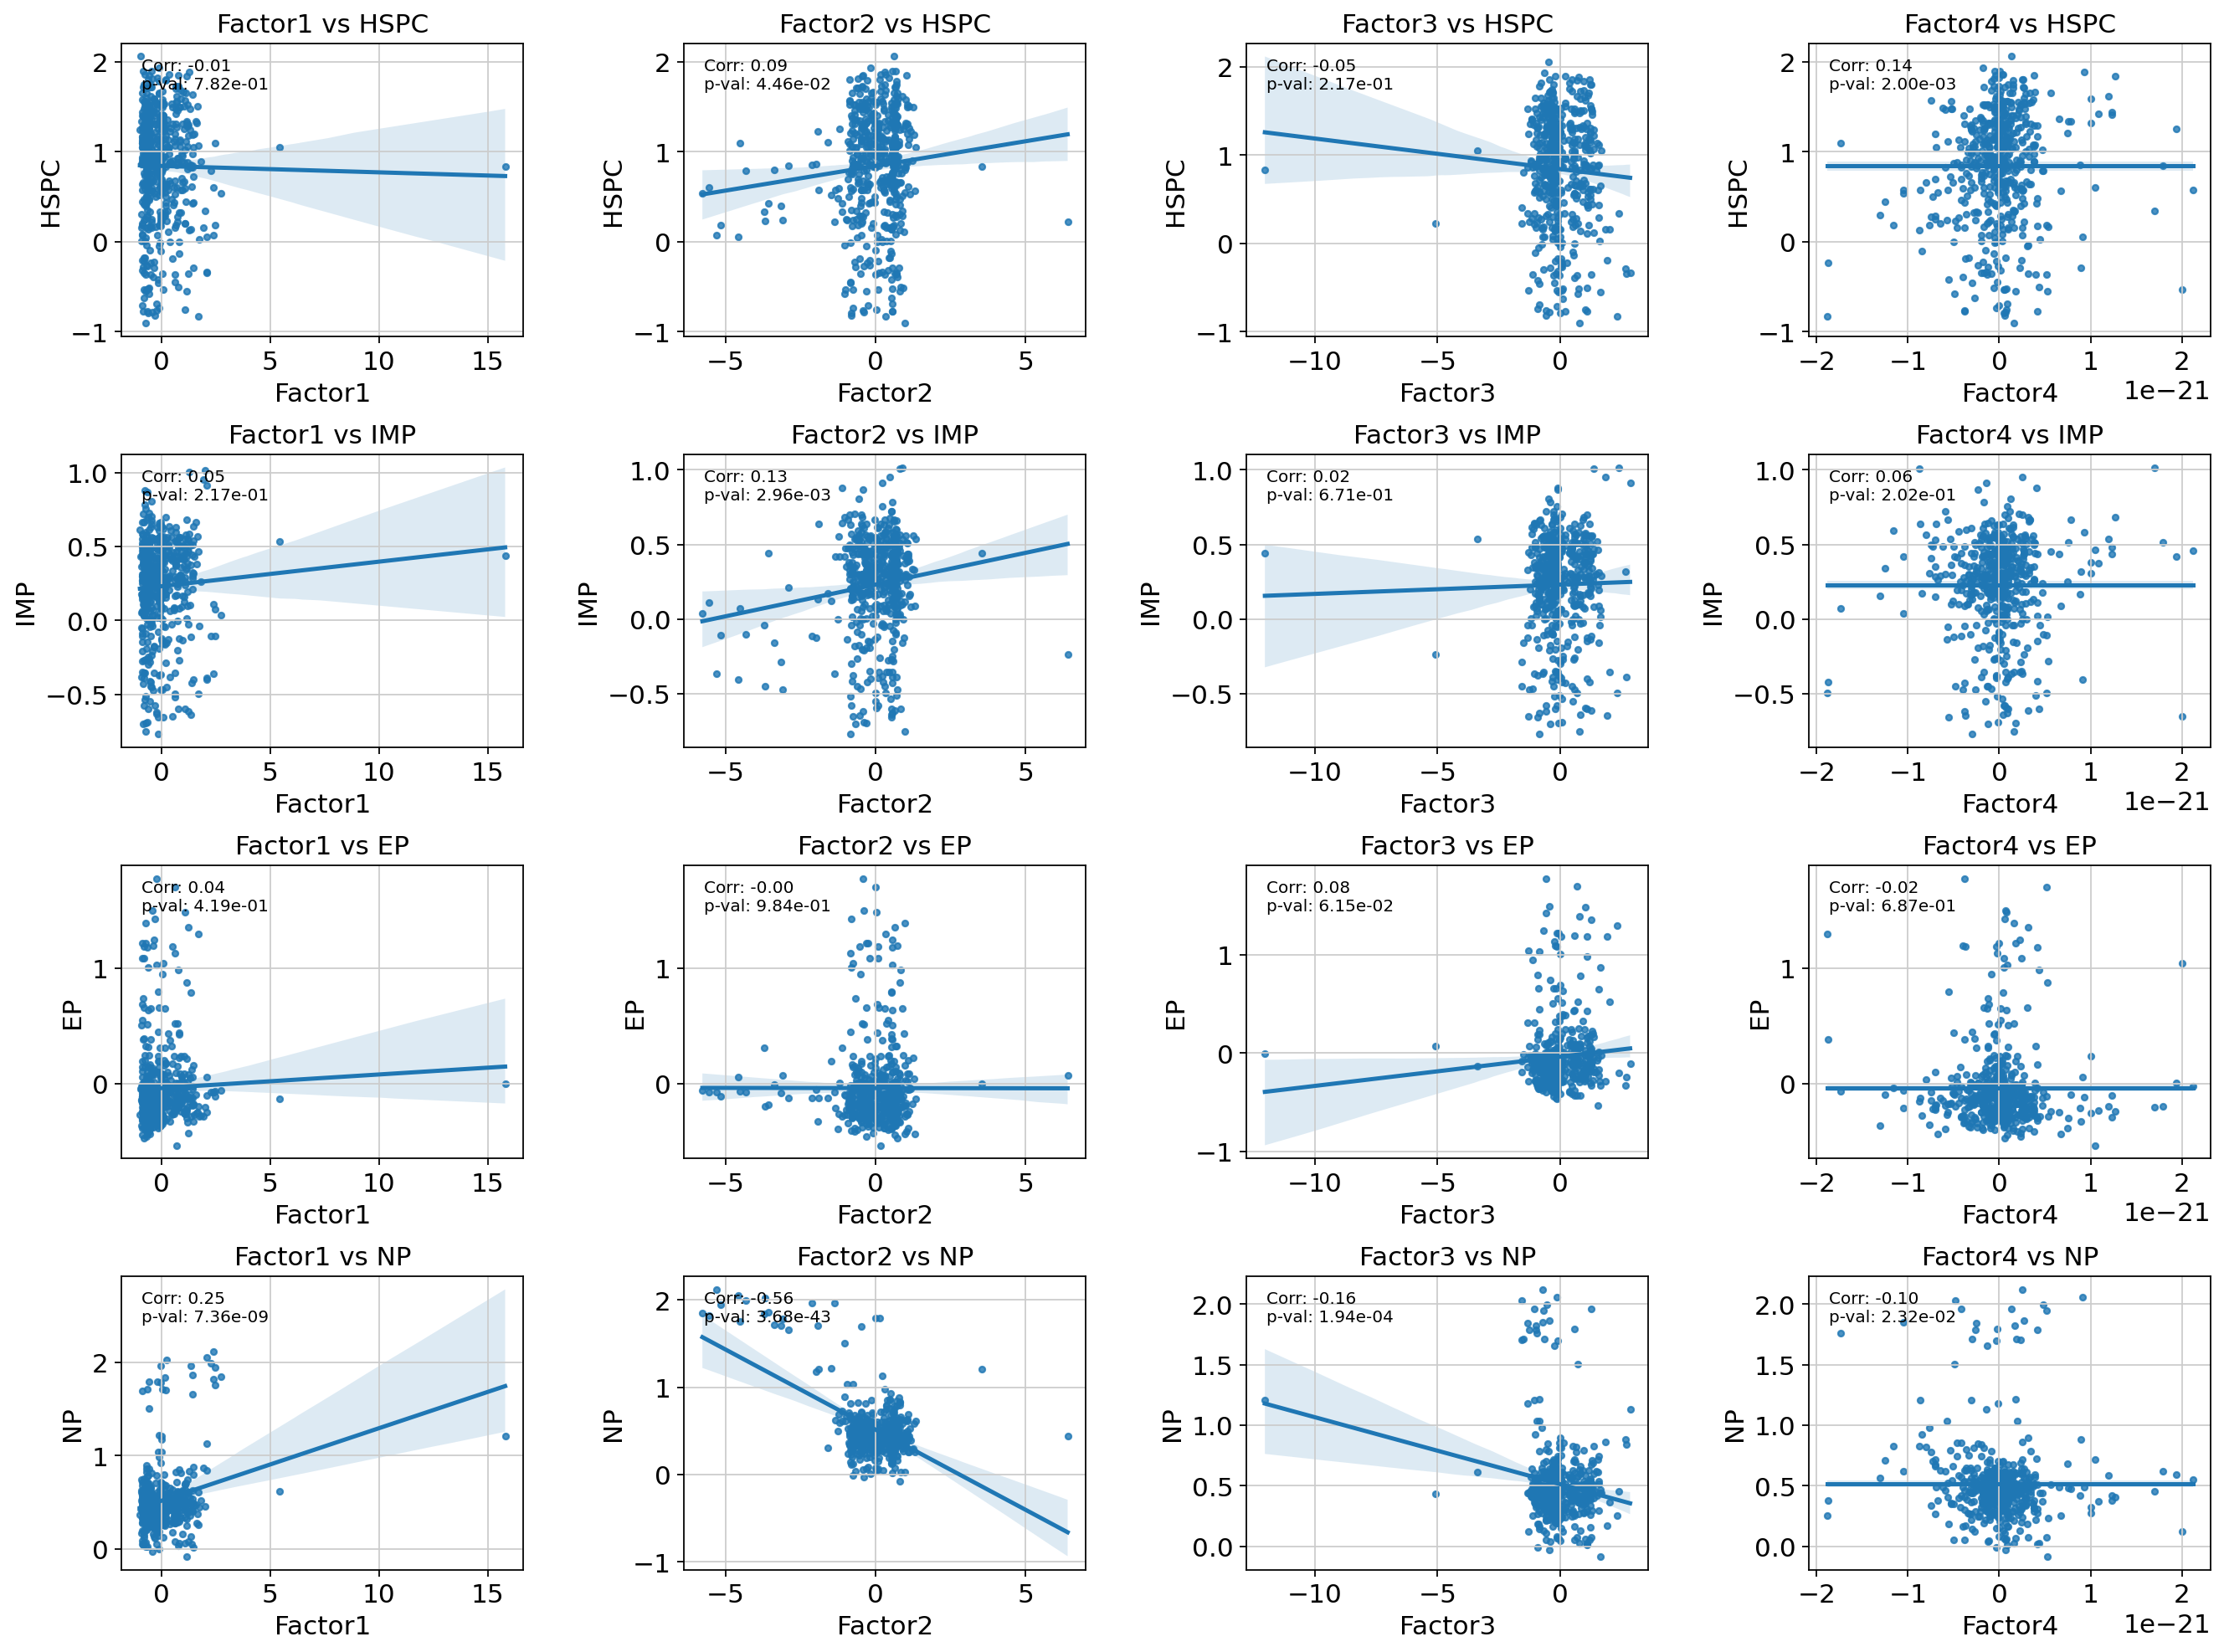

In [42]:
# Usual correlation plot
# We see how MOFA factors in this case
# are mainly driven by high variance samples

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

df = pd.concat([adata.obs, mofa_df], axis = 1)
mofa_vars = [col for col in df.columns if col.startswith('Fac')]
specific_vars = ["HSPC", "IMP", "EP", "NP"]

# Determine the size of the grid
grid_size = (len(specific_vars), len(arch_vars)) # Rows x Columns

# Create a figure to hold the grid
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjust space between plots

# Iterate over each specific variable and 'arch' variable to plot
for i, spec_var in enumerate(specific_vars):
    for j, arch_var in enumerate(mofa_vars):
        # Current axis
        ax = axes[i, j]
        
        # Plot data and regression line with seaborn
        sns.regplot(x=arch_var, y=spec_var, data=df, ax=ax, scatter_kws={'s': 10})
        
        # Calculate correlation and p-value
        corr, p_value = pearsonr(df[arch_var], df[spec_var])
        
        # Annotate plot with correlation and p-value
        ax.text(0.05, 0.95, f'Corr: {corr:.2f}\np-val: {p_value:.2e}', transform=ax.transAxes, 
                verticalalignment='top', fontsize=9)
        
        # Set title
        ax.set_title(f'{arch_var} vs {spec_var}')

# Show plot
plt.show()


In [73]:
# Here we do a Kmenas clustering with the same number of clusters as the archetypes
# For this we use the full model to be more fair in the comparison

from sklearn.cluster import KMeans

m = mfx.mofa_model("./mofa_on_emato_full.hd5")

kmeans_mofa = KMeans(n_clusters=4,  n_init="auto", random_state = 3).fit(m.get_factors())

In [74]:
adata.obs["mofa_kmeans"] = ["MOFA" + str(i) for i in kmeans_mofa.labels_]

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


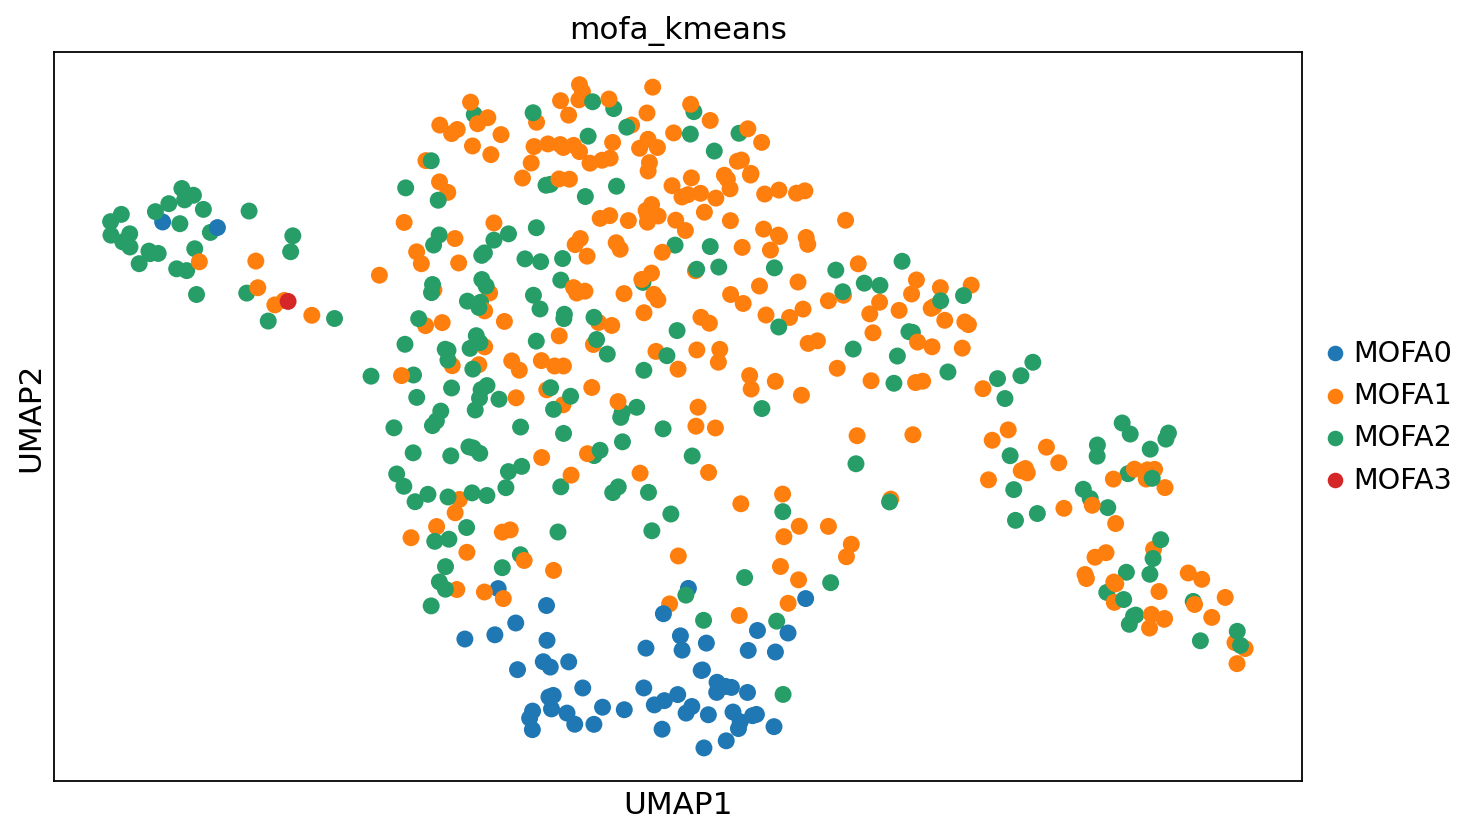

In [75]:
sc.pl.umap(adata, color=["mofa_kmeans"])

In [76]:
# We also run a vanilla multimodal-VAE 

MULT = 4


var_AA = maa.fit_maa(
    [X_rna_aa, X_meth],
    [np.ones(X_rna_aa.shape[0]), np.ones(X_meth.shape[0])],
    ["G", "B"],
    #side_matrices = [side_mat], 
    #input_types_side = ["C"],
    #loss_weights_side = [1e2],
    #loss_weights_reconstruction = [1, 1],
    hidden_dims_dec_common = [32 * MULT, 64 * MULT],
    hidden_dims_dec_last = [64 * MULT, 128 * MULT],
    hidden_dims_enc_ind = [128 * MULT, 64 * MULT],
    hidden_dims_enc_common = [64 * MULT],
    hidden_dims_enc_pre_Z = [32 * MULT],
    lr = 0.0001,
    gamma_lr = 0.1,
    steps = 1000,
    narchetypes = 5,
    batch_size = 300,
    fix_Z = False,
    just_VAE = True, # This selects the VAE option in MIDAA
    torch_seed = 3
)

ELBO: 156672.60938  : 100%|██████████| 1000/1000 [00:39<00:00, 25.16it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


In [77]:
# As usual we save the results

torch.save(var_AA["deepAA_obj"].state_dict(), "VAE_state_dict.pth")
torch.save(var_AA["inferred_quantities"], "VAE_inferred_quantities.pth")

In [78]:
# We add the new dimensions to the object

vae_df = pd.DataFrame(var_AE["inferred_quantities"]["Z"], index = adata.obs.index, columns = ["VAE_" + str(i) for i in range(1,5)])
df = pd.concat([adata.obs, vae_df], axis = 1)

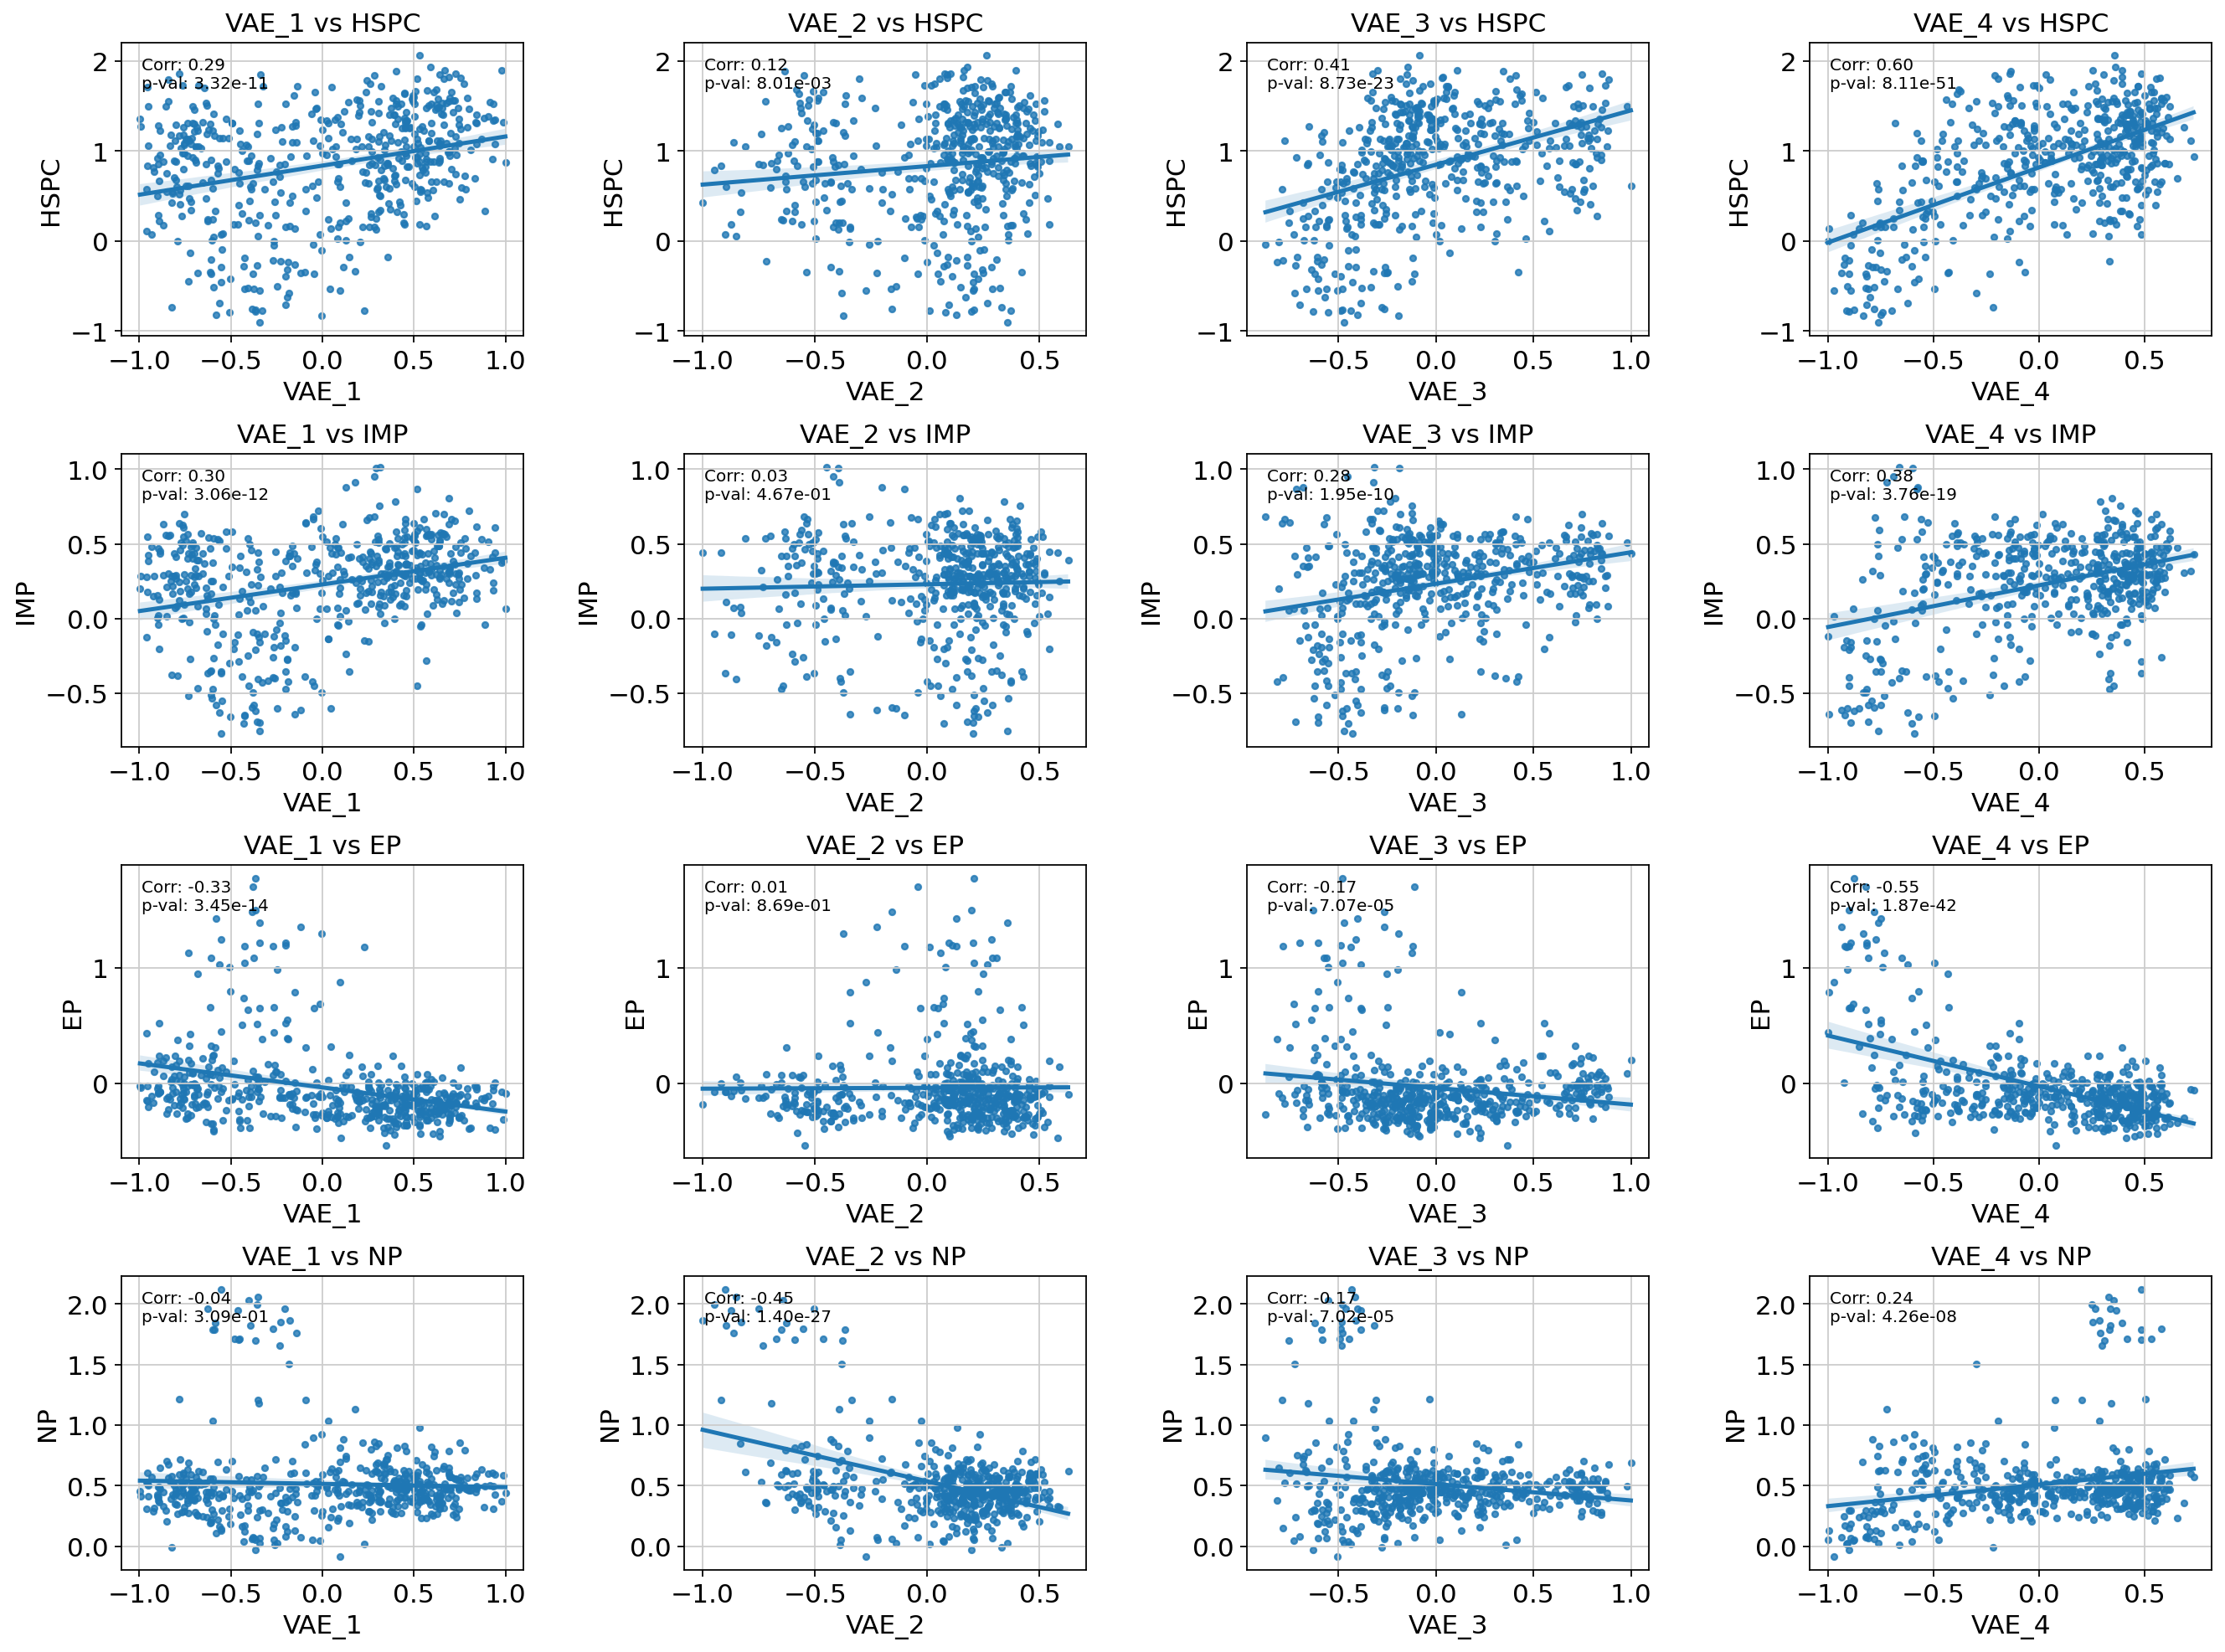

In [79]:
# And compute correlation

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

mofa_vars = [col for col in df.columns if col.startswith('VAE')]
specific_vars = ["HSPC", "IMP", "EP", "NP"]

# Determine the size of the grid
grid_size = (len(specific_vars), len(arch_vars)) # Rows x Columns

# Create a figure to hold the grid
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjust space between plots

# Iterate over each specific variable and 'arch' variable to plot
for i, spec_var in enumerate(specific_vars):
    for j, arch_var in enumerate(mofa_vars):
        # Current axis
        ax = axes[i, j]
        
        # Plot data and regression line with seaborn
        sns.regplot(x=arch_var, y=spec_var, data=df, ax=ax, scatter_kws={'s': 10})
        
        # Calculate correlation and p-value
        corr, p_value = pearsonr(df[arch_var], df[spec_var])
        
        # Annotate plot with correlation and p-value
        ax.text(0.05, 0.95, f'Corr: {corr:.2f}\np-val: {p_value:.2e}', transform=ax.transAxes, 
                verticalalignment='top', fontsize=9)
        
        # Set title
        ax.set_title(f'{arch_var} vs {spec_var}')

# Show plot
plt.savefig("VAE_vs_cell_score.pdf")

plt.show()


In [80]:
# We go for the KMeans clustering

from sklearn.cluster import KMeans

kmeans_vae = KMeans(n_clusters=4, n_init="auto", random_state = 3).fit(var_AA["inferred_quantities"]["Z"])

adata.obs["VAE_kmeans"] = ["VAE" + str(i) for i in kmeans_vae.labels_]

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


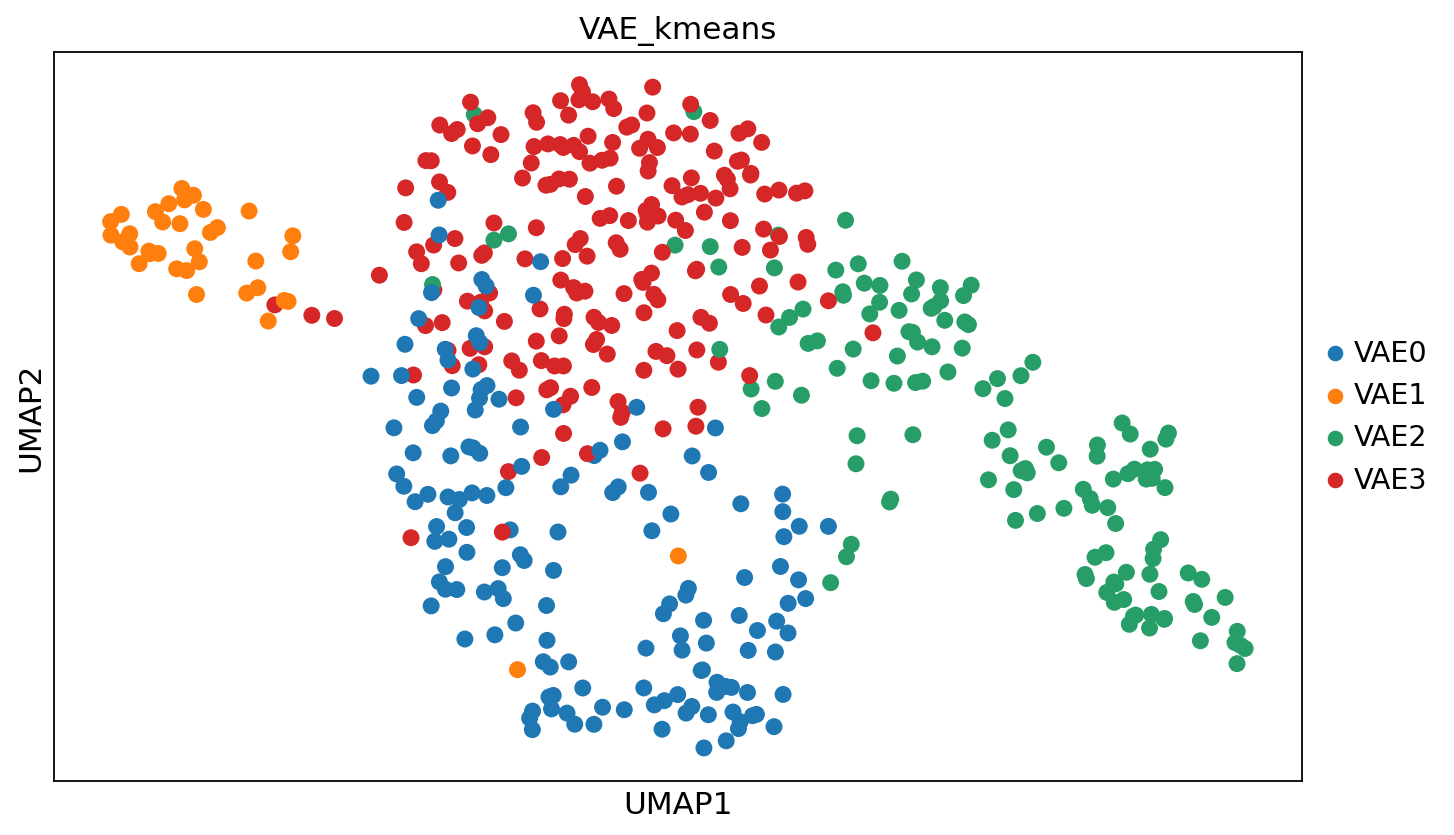

In [81]:
sc.pl.umap(adata, color=["VAE_kmeans"])

In [82]:
# Here we associate each cell to the highest archetype

# Step 1: Identify columns that start with "arch"
arch_columns = [col for col in adata.obs.columns if col.startswith('arc')]

# Step 2: Find the column name with the highest value for each row
def find_highest_arch(row):
    return row[arch_columns].astype(float).idxmax()

def find_highest_score(row):
    return row[arch_columns].astype(float).max()

adata.obs['highest_arc'] = adata.obs.apply(find_highest_arch, axis=1)
adata.obs['highest_score'] = adata.obs.apply(find_highest_score, axis=1)

In [83]:
# We take only the ones with higher score to have a distribution around the real archetypes

adata.obs["highest_arc"].iloc[np.where(adata.obs['highest_score'] < 0.8)] = "NA"

/tmp/ipykernel_725044/3372455204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["highest_arc"].iloc[np.where(adata.obs['highest_score'] < 0.8)] = "NA"


/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


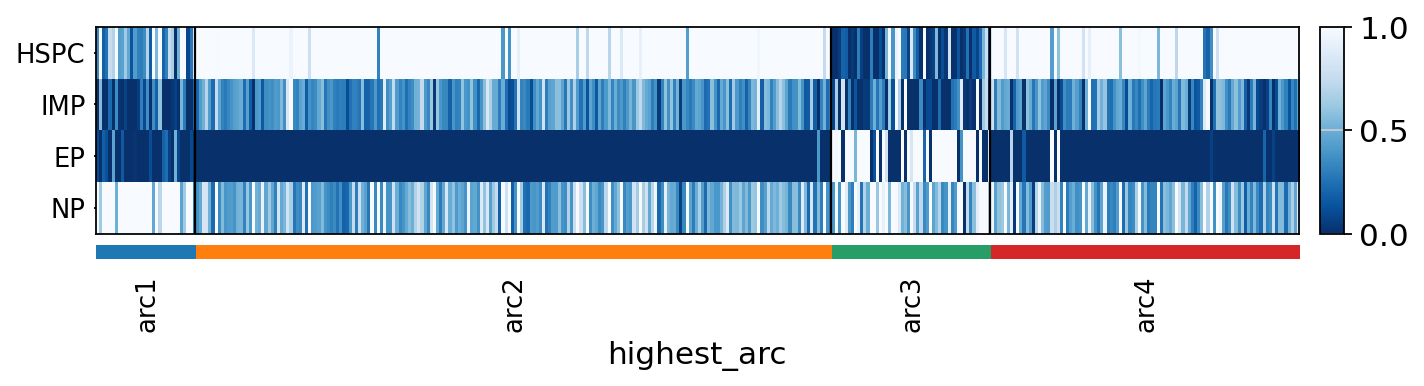

In [47]:
sc.pl.heatmap(adata[~adata.obs["highest_arc"].isin(["NA"]),:], ["HSPC", "IMP", "EP", "NP"], groupby='highest_arc', 
              swap_axes=True, standard_scale = "obs", figsize=[10,2],  cmap = "Blues_r")


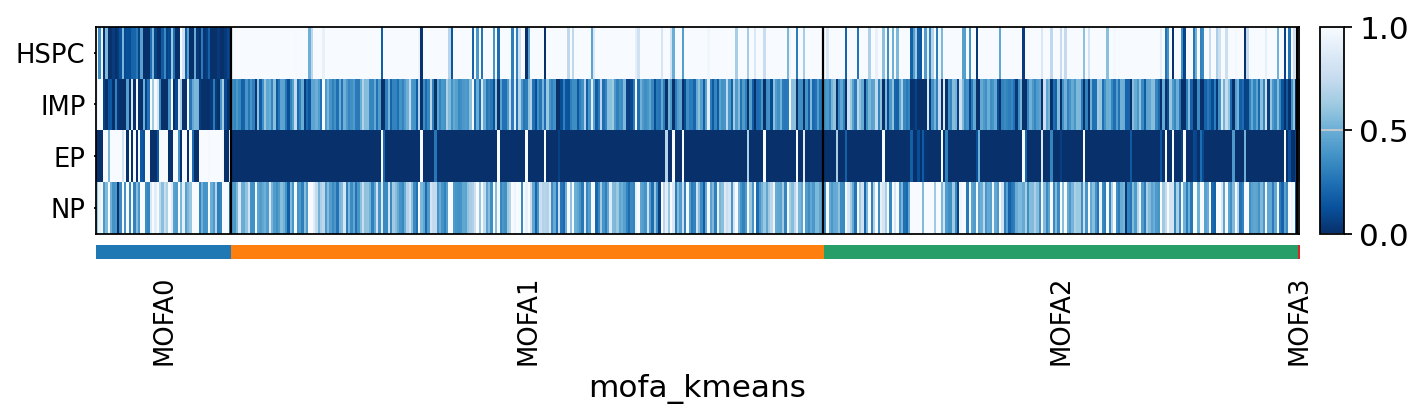

In [46]:
sc.pl.heatmap(adata, ["HSPC", "IMP", "EP", "NP"], groupby='mofa_kmeans', 
              swap_axes=True, standard_scale = "obs", figsize=[10,2], cmap = "Blues_r")

In [48]:
ax_dict = sc.pl.heatmap(adata, ["HSPC", "IMP", "EP", "NP"], groupby='VAE_kmeans', 
              swap_axes=True, standard_scale = "obs", figsize=[10,2], show=False, cmap = "Blues_r")

In [64]:
# Here we look at the silhuette score of the clusters

from sklearn.metrics import silhouette_score


sil_AA = silhouette_score(adata[~adata.obs["highest_arc"].isin(["NA"]),:].obs[["EP", "NP", "HSPC"]].values,
                 adata[~adata.obs["highest_arc"].isin(["NA"]),:].obs["highest_arc"])

sil_VAE = silhouette_score(adata.obs[["EP", "NP", "HSPC"]].values,
                 adata.obs["VAE_kmeans"])

sil_MOFA = silhouette_score(adata.obs[["EP", "NP", "HSPC"]].values,
                 adata.obs["mofa_kmeans"])



In [86]:

df_sil = pd.DataFrame({
    "silhouette_score" : [sil_AA, sil_VAE, sil_MOFA],
    "tool" : ["maa", "VAE", "MOFA"]
})

from plotnine import ggplot, geom_point, aes, geom_col, scale_fill_brewer, xlim, theme_classic, theme, ggtitle, ggsave

(
    ggplot(df_sil, aes("tool", "silhouette_score", fill="tool")) +
    geom_col() + scale_fill_brewer(palette = "Set1", type = "qual") +
    theme_classic() + theme(legend_position = "none") +
    ggtitle("")
)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2.5 x 3 in image.
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: silhuette_score.pdf


In [111]:
# We now run a GSEA on each archetype to see if they are consistent with our findings

archetypes = best_model["inferred_quantities"]["B"] @ adata.X
archetypes_df = [pd.DataFrame(archetypes[i,:], index = adata.var_names, columns = [f"arch_{i}"]) for i in range(archetypes.shape[0])]

In [112]:
import gseapy as gp

pre_res = {}

for i in range(len(archetypes_df)):
    pre_res["arc" + str(i)] = gp.prerank(rnk=archetypes_df[i], # or rnk = rnk,
                     gene_sets=scores_list,
                     threads=2,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=3,
                     ascending = True,
                     verbose=True, # see what's going on behind the scenes
                    )



2024-03-18 11:39:41,468 [INFO] Parsing data files for GSEA.............................
2024-03-18 11:39:41,469 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-03-18 11:39:41,469 [INFO] 0008 gene_sets used for further statistical testing.....
2024-03-18 11:39:41,470 [INFO] Start to run GSEA...Might take a while..................
2024-03-18 11:39:41,701 [INFO] Congratulations. GSEApy runs successfully................

2024-03-18 11:39:41,705 [INFO] Parsing data files for GSEA.............................
2024-03-18 11:39:41,706 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-03-18 11:39:41,706 [INFO] 0008 gene_sets used for further statistical testing.....
2024-03-18 11:39:41,707 [INFO] Start to run GSEA...Might take a while..................
2024-03-18 11:39:41,936 [INFO] Congratulations. GSEApy runs successfully................

2024-03-18 11:39:41,941 [INFO] Parsing data files for GSEA............................

In [113]:
long_names = ["Hematopoietic Stem and Progenitor Cells score", "Immature Myeloid Progenitors score", "Erythroid Progenitors score", "Neutrophil Progenitors score"]

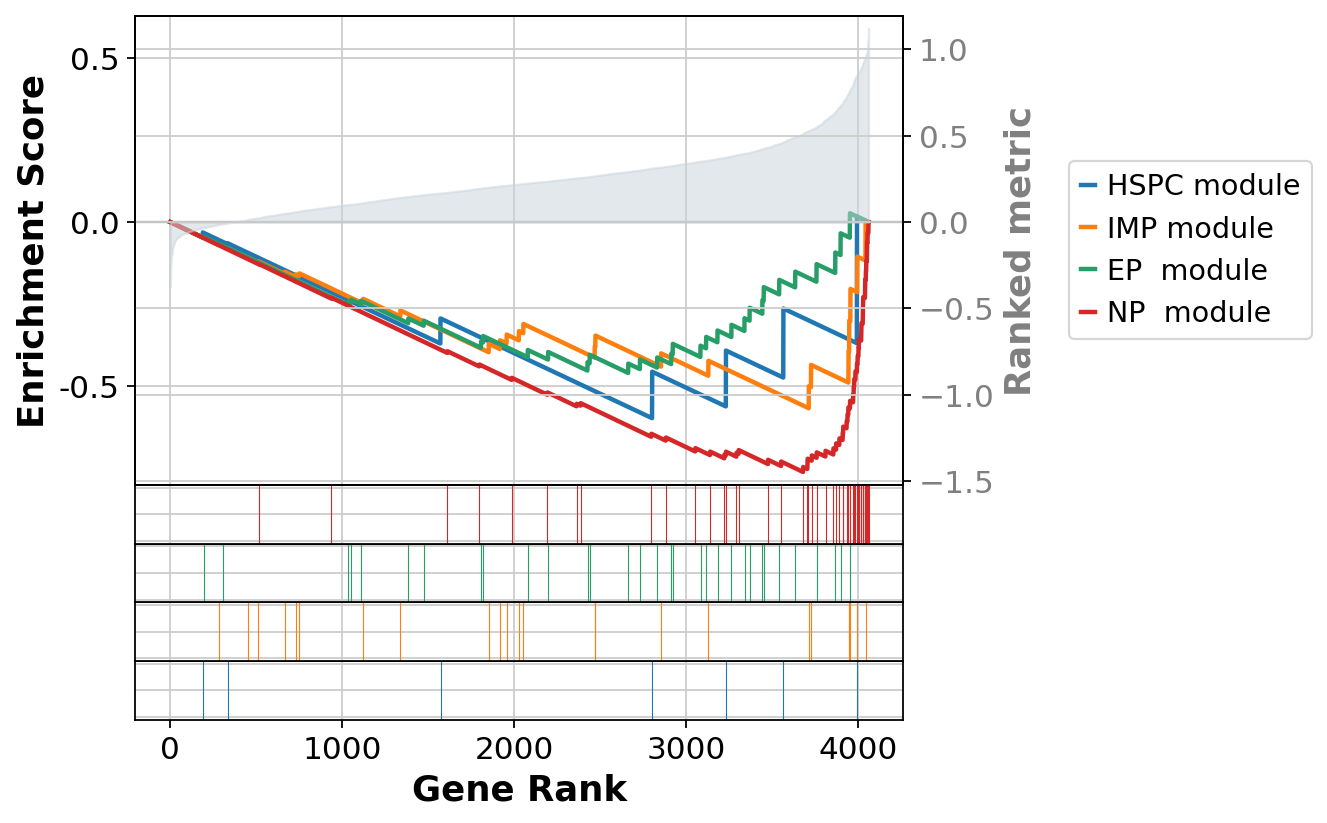

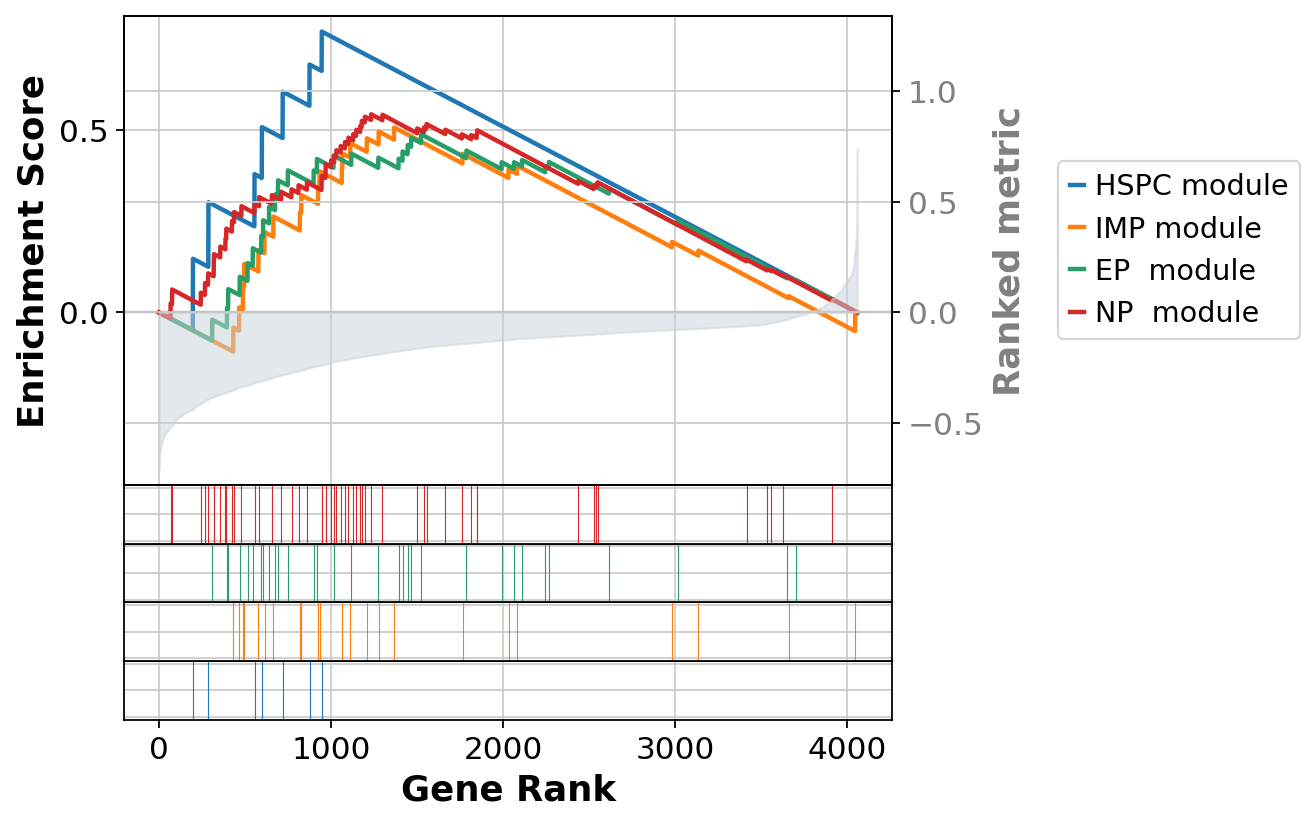

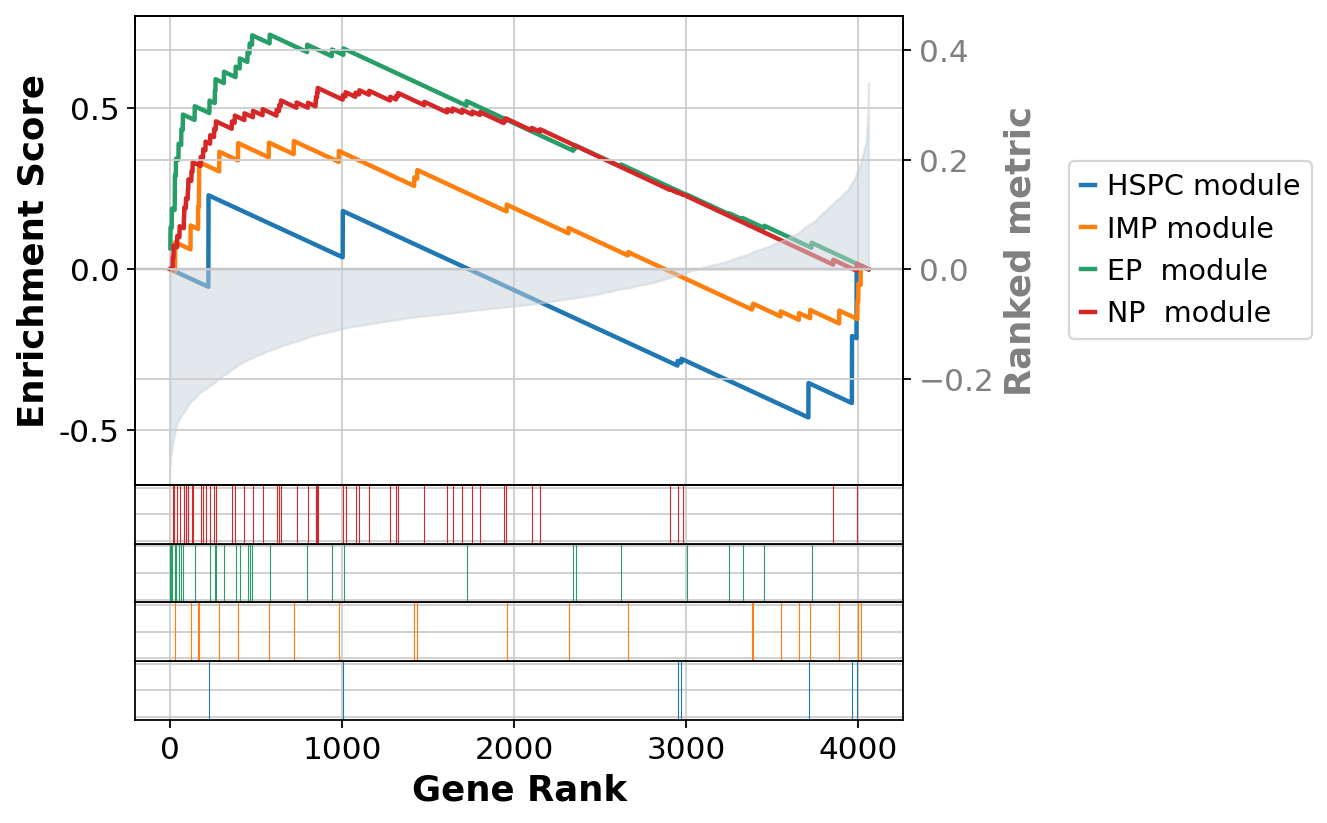

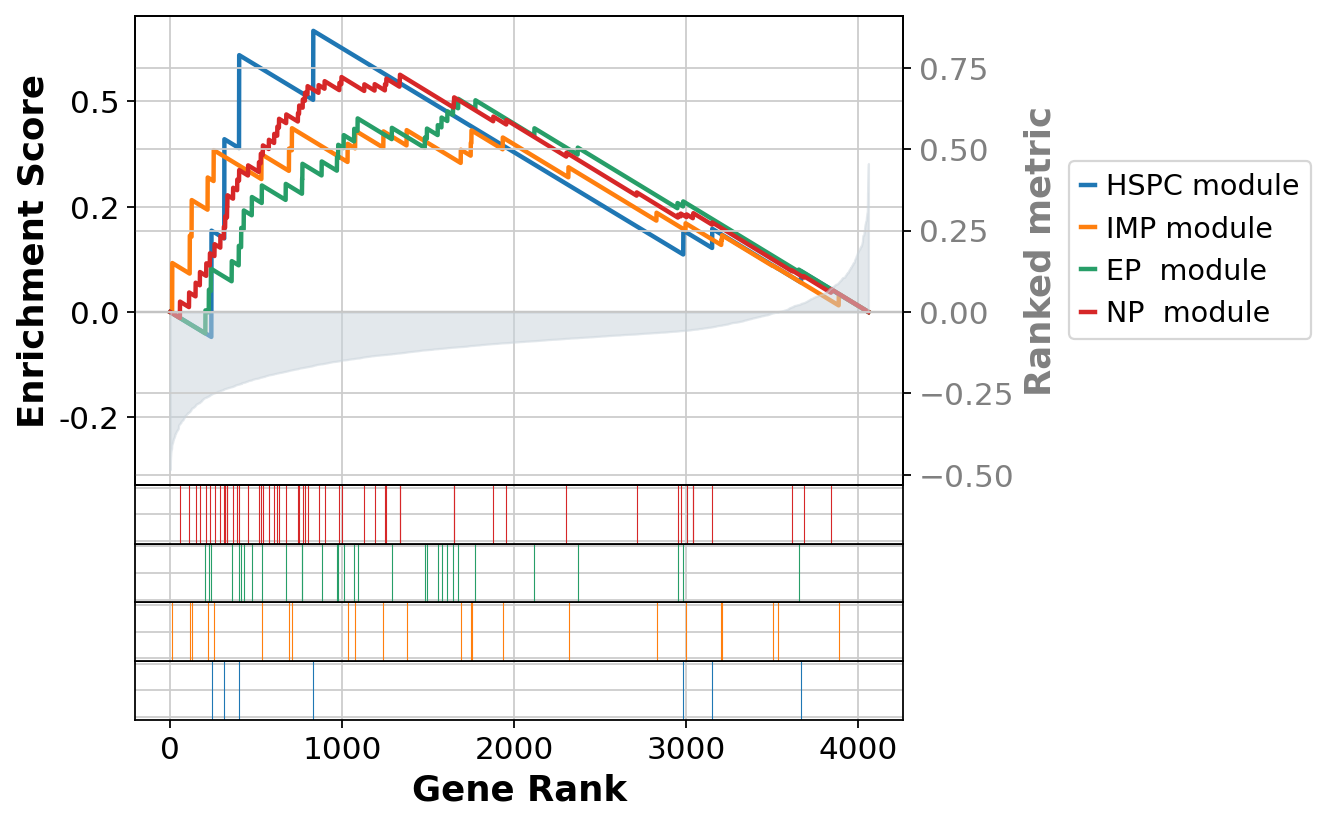

In [115]:
plt_axs = {}

for i in range(len(archetypes_df)):

    plt_axs["arc" + str(i)] = pre_res["arc" + str(i)].plot(terms=["HSPC module", "IMP module", "EP  module", "NP  module"],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(8,6),
                   legend_kws = {"loc":"right" , "bbox_to_anchor": [1.55,0.5]},
                  )
    plt_axs["arc" + str(i)].figure.savefig( "arc" + str(i) + "_GSEA.pdf", transparent= True, bbox_inches = 'tight')


In [116]:
# We save the final anndata
adata.write_h5ad("adata_final.h5ad")